# Experiments with German

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import PartialDependenceDisplay
from lime import lime_tabular
import shap
from aif360.algorithms.preprocessing import Reweighing
from fairlearn.postprocessing import ThresholdOptimizer
from fairgbm import FairGBMClassifier
from aif360.datasets import BinaryLabelDataset
from sklego.linear_model import EqualOpportunityClassifier, DemographicParityClassifier
import plotly.express as px
import plotly.graph_objects as go
import joblib

import credit_pipeline.data_exploration as dex
from credit_pipeline.training import *
import credit_pipeline.data

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


## Loading and Cleaning

In [2]:
seed_number = 0
df = credit_pipeline.data.load_dataset("german")

In [3]:
df.head()

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,OtherDebtors,ResidenceSince,...,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,Dependents,Telephone,ForeignWorker,DEFAULT,Gender
0,0 - 200,48,Existing paid,Radio/television,5951,< 100,1 - 4,2,No,2,...,22,No,Own,1,Skilled,1,0,1,1,Female
1,No,12,Critical account,Education,2096,< 100,4 - 7,2,No,3,...,49,No,Own,1,Unskilled,2,0,1,0,Male
2,< 0,42,Existing paid,Furniture/equipment,7882,< 100,4 - 7,2,Guarantor,4,...,45,No,For free,1,Skilled,2,0,1,0,Male
3,< 0,24,Delay in paying,Car (new),4870,< 100,1 - 4,3,No,4,...,53,No,For free,2,Skilled,2,0,1,1,Male
4,No,36,Existing paid,Education,9055,Unknown/None,1 - 4,2,No,4,...,35,No,For free,1,Unskilled,2,1,1,0,Male


In [4]:
X_acp = df.iloc[:, (df.columns != "DEFAULT")]
y_acp = df["DEFAULT"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_acp, 
    y_acp, 
    test_size = 0.2, 
    random_state=seed_number, 
    stratify=y_acp
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size = 0.2, 
    random_state=seed_number, 
    stratify=y_train
)
A_train = (X_train.Gender == "Female").astype(int)
A_val = (X_val.Gender == "Female").astype(int)
A_test = (X_test.Gender == "Female").astype(int)

## Training Basic Models

In [6]:
n_trials = 100

In [ ]:
study_logistic, model_logistic = optimize_model(
    LogisticRegression, 
    {"onehot" : True, "normalize" : True},
    hyperparam_spaces["LogisticRegression"], 
    X_train, 
    y_train, 
    X_val , 
    y_val, 
    cv = 5,
    n_trials=n_trials
)
joblib.dump(model_logistic, "../results/models/german_logistic.joblib")

In [8]:
print("Score for Logistic Regression: ", study_logistic.best_value)
print(study_logistic.best_params)

Score for Logistic Regression:  0.7922760011524057
{'C': 0.09263194897040856, 'max_iter': 1000, 'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'liblinear'}


In [ ]:
study_rf, model_rf = optimize_model(
    RandomForestClassifier, 
    {"onehot" : True, "normalize" : True},
    hyperparam_spaces["RandomForestClassifier"], 
    X_train, 
    y_train, 
    X_val , 
    y_val, 
    cv = 5,
    n_trials=n_trials
)
joblib.dump(model_rf, "../results/models/german_rf.joblib")

In [10]:
print("Score for Random Forest: ", study_rf.best_value)
print(study_rf.best_params)

Score for Random Forest:  0.7875377943562449
{'n_estimators': 130, 'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 16, 'max_features': 0.1312969976921862, 'class_weight': None}


In [ ]:
study_lgbm, model_lgbm = optimize_model(
    LGBMClassifier,
    {"onehot" : True, "normalize" : True},
    hyperparam_spaces["LGBMClassifier"], 
    X_train, 
    y_train, 
    X_val , 
    y_val, 
    cv = 5,
    n_trials=n_trials
)
joblib.dump(model_lgbm, "../results/models/german_lgbm.joblib")

In [12]:
print("Score for LGBM: ", study_lgbm.best_value)
print(study_lgbm.best_params)

Score for LGBM:  0.7898152612877627
{'learning_rate': 0.06925540311919266, 'num_leaves': 80, 'max_depth': 8, 'min_child_samples': 41, 'colsample_bytree': 0.17752500137553326, 'reg_alpha': 0.9267397632120886, 'reg_lambda': 0.35220377663148034, 'n_estimators': 90, 'class_weight': None, 'verbose': -1}


In [ ]:
study_mlp, model_mlp = optimize_model(
    MLPClassifier, 
    {"onehot" : True, "normalize" : True},
    hyperparam_spaces["MLPClassifier"], 
    X_train, 
    y_train, 
    X_val , 
    y_val, 
    cv = 5,
    n_trials=n_trials
)
joblib.dump(model_mlp, "../results/models/german_mlp.joblib")

In [14]:
print("Score for MLP: ", study_mlp.best_value)
print(study_mlp.best_params)

Score for MLP:  0.7862148023472683
{'hidden_layer_sizes': [256, 128, 64, 32, 16], 'alpha': 0.00011828207596057266, 'learning_rate': 'constant', 'learning_rate_init': 0.003284948835493599, 'early_stopping': True, 'max_iter': 50}


## Model evaluation

In [16]:
models = {
    "LogisticRegression" : joblib.load("../results/models/german_logistic.joblib"),
    "MLPClassifier" : joblib.load("../results/models/german_mlp.joblib"),
    "RandomForestClassifier" : joblib.load("../results/models/german_rf.joblib"),
    "LGBMClassifier" : joblib.load("../results/models/german_lgbm.joblib"),
}
ks_threshold_dict = {}
models_dict = {}
for n, m in models.items():
    ks_threshold_dict[n] = ks_threshold(y_val, m.predict_proba(X_val)[:,1])
    models_dict[n] = [
        m,
        ks_threshold_dict[n]
    ]
ks_threshold_dict

{'LogisticRegression': 0.5718538171018251,
 'MLPClassifier': 0.037273407367181224,
 'RandomForestClassifier': 0.36998243354350385,
 'LGBMClassifier': 0.3624744889364732}

In [17]:
get_metrics(models_dict, X_train, y_train)

,AUC,Balanced Accuracy,Accuracy,Precision,Recall,F1,Brier Score
LogisticRegression,0.839381,0.742712,0.766823,0.598174,0.682292,0.637470,0.167982
MLPClassifier,0.975030,0.807641,0.743349,0.540698,0.968750,0.694030,0.042950
RandomForestClassifier,0.868254,0.772127,0.793427,0.638889,0.718750,0.676471,0.158773
LGBMClassifier,0.889879,0.802241,0.804382,0.640167,0.796875,0.709977,0.134146


In [18]:
get_metrics(models_dict, X_val, y_val)

,AUC,Balanced Accuracy,Accuracy,Precision,Recall,F1,Brier Score
LogisticRegression,0.783110,0.750000,0.75000,0.562500,0.750000,0.642857,0.200596
MLPClassifier,0.751860,0.724702,0.65625,0.462366,0.895833,0.609929,0.230912
RandomForestClassifier,0.761161,0.724702,0.73125,0.539683,0.708333,0.612613,0.178260
LGBMClassifier,0.761347,0.727679,0.71875,0.521739,0.750000,0.615385,0.175190


In [19]:
get_metrics(models_dict, X_test, y_test)

,AUC,Balanced Accuracy,Accuracy,Precision,Recall,F1,Brier Score
LogisticRegression,0.757738,0.677381,0.715,0.522388,0.583333,0.551181,0.201316
MLPClassifier,0.719524,0.658333,0.595,0.411765,0.816667,0.547486,0.221596
RandomForestClassifier,0.778571,0.717857,0.745,0.565217,0.650000,0.604651,0.177931
LGBMClassifier,0.765357,0.700000,0.720,0.527027,0.650000,0.582090,0.172664


In [20]:
models_dict_fairness = {}
for n, m in models_dict.items():
    models_dict_fairness[n] = (m[0].predict_proba(X_test)[:,1] > m[1]).astype(int)

In [21]:
get_fairness_metrics(models_dict_fairness, y_test, A_test, 1)

,DPD,EOD,AOD,APVD,GMA,balanced_accuracy
LogisticRegression,-0.002433,-0.059809,-0.036310,0.072344,0.710417,0.677381
MLPClassifier,0.035106,-0.069378,-0.008821,0.069484,0.588382,0.658333
RandomForestClassifier,0.168347,0.122010,0.133683,-0.000722,0.731628,0.717857
LGBMClassifier,0.108678,0.122010,0.091185,0.039011,0.718445,0.700000


## Fairness

In [16]:
pipeline_preprocess = create_pipeline(
    X_train,
    y_train,
    lambda x : x,
)[:-1]
pipeline_preprocess.fit(X_train, y_train)
preprocess_column_names = pipeline_preprocess.get_feature_names_out()
X_train_preprocess = pipeline_preprocess.transform(X_train)
X_val_preprocess = pipeline_preprocess.transform(X_val)
X_test_preprocess = pipeline_preprocess.transform(X_test)

### Pre-processing (Reweighing / AIF360)

In [17]:
df_rw = pd.DataFrame(
    X_train_preprocess,
    columns = preprocess_column_names
)
df_rw["GoodCustomer"] = y_train.values
x_train_aif = BinaryLabelDataset(
    df = df_rw,
    label_names = ["GoodCustomer"],
    protected_attribute_names = ["cat__Gender_Female"]
)
rw = Reweighing(
    unprivileged_groups = [{"cat__Gender_Female": 1}],
    privileged_groups = [{"cat__Gender_Female": 0}],
)
rw.fit(x_train_aif)
rw_weights = rw.transform(x_train_aif).instance_weights

In [18]:
for n in ["LogisticRegression", "RandomForest", "LightGBM"]:
    best_params = models[n]["classifier"].get_params()
    rw_model = classifiers[n](**best_params)
    rw_model.fit(X_train_preprocess, y_train, sample_weight=rw_weights)
    rw_threshold = ks_threshold(y_val, rw_model.predict_proba(X_val_preprocess)[:,1])
    models_dict_fairness[n + "Reweighing"] = rw_model.predict_proba(X_test_preprocess)[:,1] > rw_threshold

### In-processing

#### EqualOpportunityClassifier

In [19]:
gender_col_idx = np.where(preprocess_column_names == "cat__Gender_Female")[0][0]
eop_class = create_pipeline(
    X_train,
    y_train,
    EqualOpportunityClassifier(
        covariance_threshold = 0.1,
        sensitive_cols = gender_col_idx,
        positive_target = 1
    )
)
eop_class.fit(X_train, y_train)
eoq_ks_threshold = ks_threshold(y_val, eop_class.predict_proba(X_val)[:,1])
models_dict_fairness["EqualOpportunity"] = eop_class.predict_proba(X_test)[:,1] > eoq_ks_threshold
dop_class = create_pipeline(
    X_train,
    y_train,
    DemographicParityClassifier(
        covariance_threshold = 0.1,
        sensitive_cols = gender_col_idx,
    )
)
dop_class.fit(X_train, y_train)
dop_ks_threshold = ks_threshold(y_val, dop_class.predict_proba(X_val)[:,1])
models_dict_fairness["DemographicParity"] = dop_class.predict_proba(X_test)[:,1] > dop_ks_threshold

#### FairGBM

In [20]:
fairgbm_params = models["LightGBM"]["classifier"].get_params()
del fairgbm_params["objective"]
fairgbm = FairGBMClassifier(
    constraint_type="FNR",
    **fairgbm_params
)
fairgbm.fit(X_train_preprocess, y_train, constraint_group=A_train)
fairgbm_threshold = ks_threshold(y_val, fairgbm.predict_proba(X_val_preprocess)[:,1])
models_dict_fairness["FairGBM"] =fairgbm.predict_proba(X_test_preprocess)[:,1] > fairgbm_threshold

### Post-processing (Threshold-Optimizer / FairLearn)

In [21]:
model_dict_thr_opt = {}
for name, model in models_dict.items():
    thr_opt = ThresholdOptimizer(
        estimator=model[0],
        constraints="equalized_odds",
        objective="balanced_accuracy_score",
        prefit=True,
        predict_method="predict_proba",
    )
    thr_opt.fit(X_train, y_train, sensitive_features=A_train)
    models_dict_fairness[name + "Thr.Opt."] = thr_opt.predict(X_test, sensitive_features=A_test)

### Fairness Evaluation

In [22]:
df_metrics_results = get_fairness_metrics(
    models_dict_fairness,
    y_test,
    A_test,
    1
)
df_metrics_results_ = df_metrics_results.copy().reset_index()
df_metrics_results_.to_csv("results/german_fairness_metrics.csv", index=False)

In [24]:
df_metrics_results_[["index", "AOD", "balanced_accuracy"]].round(3)

,index,AOD,balanced_accuracy
0,LogisticRegression,-0.129,0.686
1,MLP,-0.214,0.693
2,RandomForest,-0.144,0.725
3,LightGBM,-0.160,0.705
4,LogisticRegressionReweighing,-0.058,0.727
5,RandomForestReweighing,0.006,0.713
6,LightGBMReweighing,-0.024,0.742
7,EqualOpportunity,0.024,0.710
8,DemographicParity,0.000,0.718
9,FairGBM,-0.160,0.705


In [16]:
# Mapping each model to a unique color
color_mapping = {model: idx for idx, model in enumerate(df_metrics_results_["index"].unique())}

# Adjust fairness metrics to be "the higher the better" and scale them to be between 0 and 100
#for col in ['DPD', 'EOD', 'AOD', 'APVD']:
#    df_metrics_results_[col] = (1 - np.abs(df_metrics_results_[col])) * 100

# Scale the performance metrics to be between 0 and 100
#df_metrics_results_['GMA'] *= 100
#df_latest_adjusted['balanced_accuracy'] *= 100

# Generate the required number of colors from the Viridis colorscale
num_colors = len(color_mapping)
#colors = px.colors.qualitative.Dark2
colors = px.colors.sequential.Viridis
manual_colors = [colors[i * (len(colors) - 1) // (num_colors - 1)] for i in range(num_colors)]                                                              
# Create the Advanced Parallel Coordinates Plot with adjusted data
fig = go.Figure(data=
    go.Parcoords(
        line=dict(color=df_metrics_results_['index'].map(color_mapping), showscale=False),
        dimensions=[
            dict(label='DPD', values=df_metrics_results_['DPD'], range=[-0.35, 0.1]),
            dict(label='EOD', values=df_metrics_results_['EOD'], range=[-0.35, 0.1]),
            dict(label='AOD', values=df_metrics_results_['AOD'], range=[-0.35, 0.1]),
            dict(label='APVD', values=df_metrics_results_['APVD'], range=[-0.35, 0.1]),
            dict(label='-1 * GMA', values= -df_metrics_results_['GMA']),#, range=[0, 100]),
            dict(label='-1 * Balanced Acc.', values= - df_metrics_results_['balanced_accuracy'])#, range=[65, 100])
        ]
    )
)

# Add models to the legend using the dummy scatter plot approach and specified manual colors
for idx, (model, color) in enumerate(color_mapping.items()):
    fig.add_trace(
        go.Scatter(x=[None], y=[None],
                   mode='markers',
                   marker=dict(size=10, color=manual_colors[idx]),
                   name=model,
                   showlegend=True)
    )

# remove grid from plot
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black'
)

# remove xticks from plot
fig.update_xaxes(showticklabels=False)

# Update the layout and adjust the top margin
fig.update_layout(title='Fairness Metrics German', margin=dict(t=100))

# Show the plot
fig.show()

# save fig
fig.write_image("results/german_fairness_metrics.pdf")

## Explainability

### Preparing model and dataset for explainability

In [64]:
selected_model = "LightGBM"

In [86]:
preprocess = models[selected_model][:2]
final_model = models[selected_model][2:]

In [87]:
# input data to techniques
X_train_preprocess = preprocess.transform(X_train)
X_test_preprocess = preprocess.transform(X_test)

In [88]:
features_names = X_train_preprocess.columns.to_list()
categorical_features_names = obj_cols
categorical_features_idx = [features_names.index(feat) for feat in categorical_features_names]
categorical_names = {}
for i, feat in enumerate(categorical_features_names):
    idx = categorical_features_idx[i]
    categorical_names[idx] = models[selected_model][1].transformers_[1][1].categories_[i].tolist()
    categorical_names[idx] = dict([(i, cat) for i, cat in enumerate(categorical_names[idx])])

print(categorical_features_names)
print(categorical_names)

['Gender', 'PurposeOfLoan']
{27: {0: 'Female', 1: 'Male'}, 28: {0: 'Business', 1: 'Education', 2: 'Electronics', 3: 'Furniture', 4: 'HomeAppliances', 5: 'NewCar', 6: 'Other', 7: 'Repairs', 8: 'Retraining', 9: 'UsedCar'}}


### PDP

In [89]:
def PDP(model, X, features_to_analyze, categorical_features_names):
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features_to_analyze,
        categorical_features=categorical_features_names,
    )

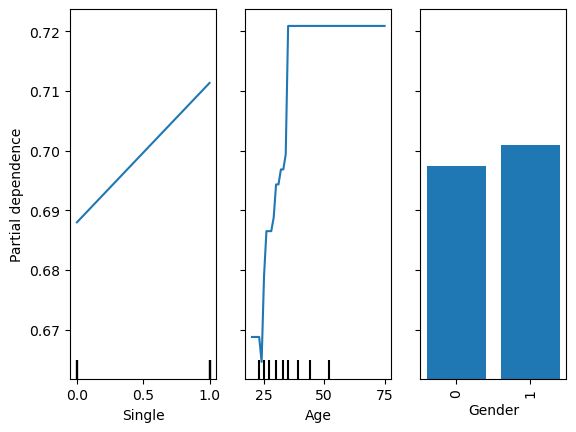

In [90]:
PDP(
    models[selected_model][2:],
    X_train_preprocess,
    ["Single", "Age", "Gender"],
    categorical_features_names
)

### ICE

In [91]:
def ICE(model, X, features_to_analyze, categorical_features_names):
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features_to_analyze,
        categorical_features=categorical_features_names,
        kind = "both",
    )

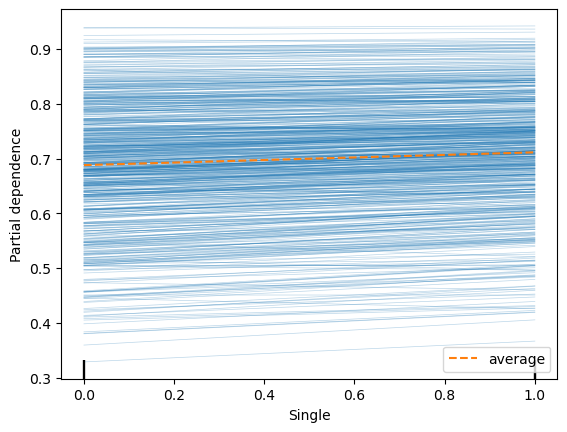

In [92]:
ICE(
    models[selected_model][2:],
    X_train_preprocess,
    ["Single"],
    categorical_features_names
)

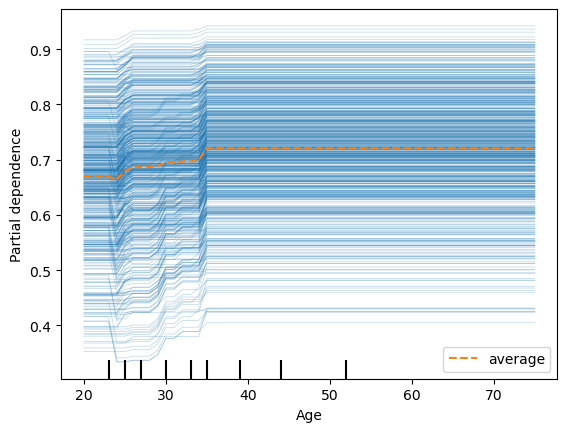

In [93]:
ICE(
    models[selected_model][2:],
    X_train_preprocess,
    ["Age"],
    categorical_features_names
)

### LIME

In [94]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train_preprocess.values,
    feature_names=features_names,
    class_names=["GoodCustomer"],
    categorical_features=categorical_features_idx,
    categorical_names=categorical_names,
    discretize_continuous=True,
)

In [95]:
idx = np.random.randint(0, len(X_test_preprocess))
def prediction_wrapper(data_array):
    temp_df = pd.DataFrame(data_array, columns=features_names)
    return models[selected_model][2:].predict_proba(temp_df)
    

explainer.explain_instance(
    X_test_preprocess.values[idx],
    prediction_wrapper,
    num_features=5,
    top_labels=1,
).show_in_notebook(show_table=True, show_all=False)

### SHAP

In [96]:
explainer = shap.Explainer(
    lambda x : models[selected_model][2:].predict_proba(x)[:, 0],
    X_train_preprocess,
    #feature_names=features_names,
    #class_names=["GoodCustomer"],
    #categorical_features=categorical_features,
    #categorical_names=categorical_names,
)

Permutation explainer: 641it [00:59,  9.30it/s]                         


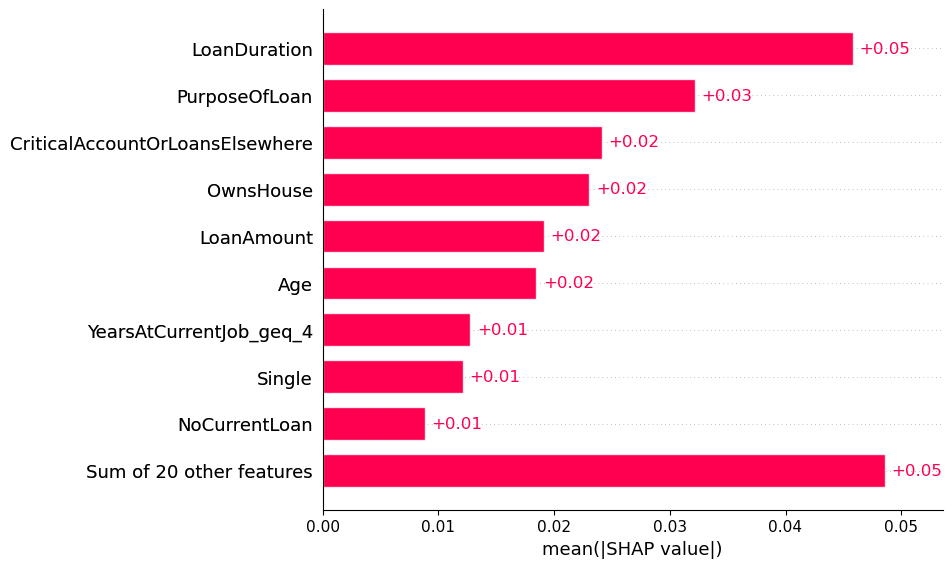

In [97]:
shap_values = explainer(X_train_preprocess)

shap.plots.bar(shap_values)
#shap.plots.beeswarm(shap_values)

/home/giovani/anaconda3/envs/credit_pipeline/lib/python3.8/site-packages/shap/plots/_beeswarm.py:375: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



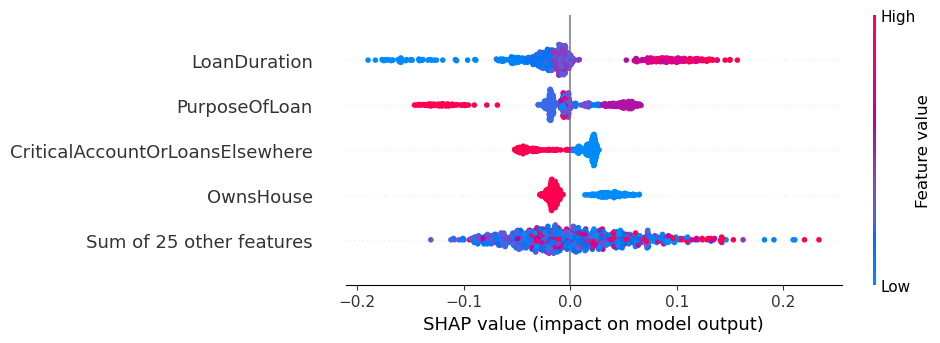

In [98]:
shap.plots.beeswarm(shap_values, max_display=5)